# Data Pre-Processing

#### Import Packages and CSV

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

In [57]:
df = pd.read_csv('data/shipment.csv')
df.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23


## Data Cleaning

#### Check Null Values

In [58]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Artist Reputation 11.53846 % missing values
Height 5.76923 % missing values
Width 8.98462 % missing values
Weight 9.03077 % missing values
Material 11.75385 % missing values
Transport 21.41538 % missing values
Remote Location 11.86154 % missing values


**What does NaN mean?**

**Ans:** Missing Values in a DataFrame

**Why might a value be missing?** 

**Ans:** When considering the potential impact of the missing data on the Dataset, it is important to consider the underlying reasons for why the data are missing
Missing data are of three categories:
* Missing completely at random (MCAR)
* Missing at random (MAR).
* Missing not at random (MNAR). 

Here it is MCAR type of missing values in dataset which are Missing completely at Random. 

When we make this assumption, we are assuming the missing data is completely unrelated to the other information in the data.

#### Checking duplicated values


In [59]:
df.duplicated().sum()

0

 * There are no duplicates values in the data

#### Seperating Features


In [60]:
target_feature = 'Cost'

# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
numeric_features.remove(target_feature)
non_numeric_features = [feature for feature in df.columns if df[feature].dtype == 'O']

print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} Non Numeric features : {}'.format(len(non_numeric_features), non_numeric_features))

We have 6 numerical features : ['Artist Reputation', 'Height', 'Width', 'Weight', 'Price Of Sculpture', 'Base Shipping Price']

We have 13 Non Numeric features : ['Customer Id', 'Artist Name', 'Material', 'International', 'Express Shipment', 'Installation Included', 'Transport', 'Fragile', 'Customer Information', 'Remote Location', 'Scheduled Date', 'Delivery Date', 'Customer Location']


Imputing null values with median to check the multicollinearity

In [61]:
df1 = df.copy()
for i in numeric_features:
    df1[i].fillna(df1[i].median(), inplace=True)

### Multicollinearity Check
#### Variance Inflation Factor (VIF)

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [62]:
import statsmodels.api as sm

for i in range(0, len(numeric_features)):
    x = df1.loc[:, df1.columns == numeric_features[i]]
    y = df1.Cost
    model = sm.OLS(x,y)
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            numeric_features[i], vif)
        )


Variance Inflation Factor of Artist Reputation column is 1.01 

Variance Inflation Factor of Height column is 1.01 

Variance Inflation Factor of Width column is 1.02 

Variance Inflation Factor of Weight column is 1.2 

Variance Inflation Factor of Price Of Sculpture column is 1.3 

Variance Inflation Factor of Base Shipping Price column is 1.01 



### Note:  All the columns has VIF around 1, so there is not severe multicollinearity

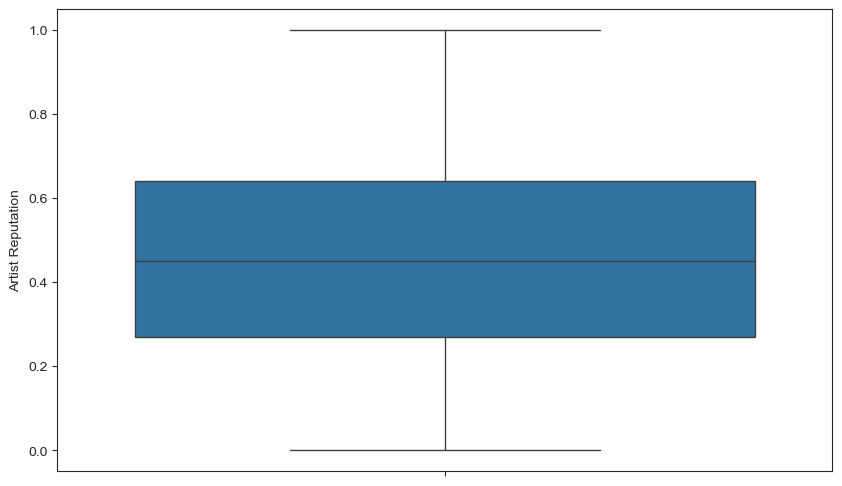

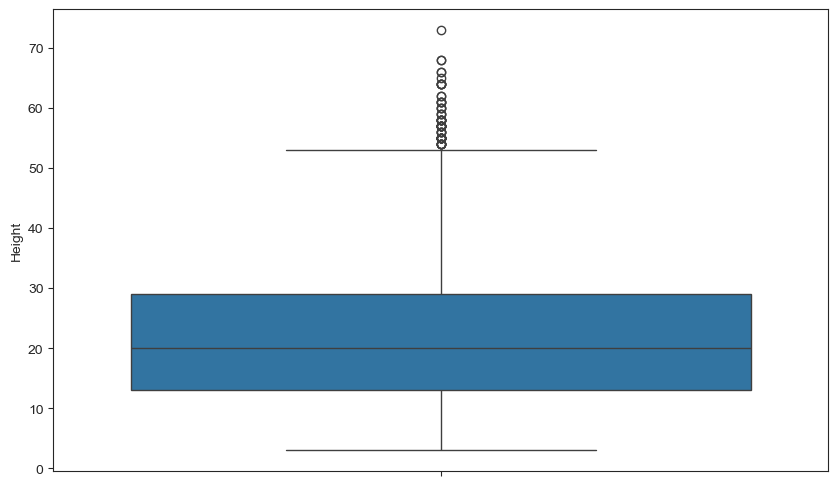

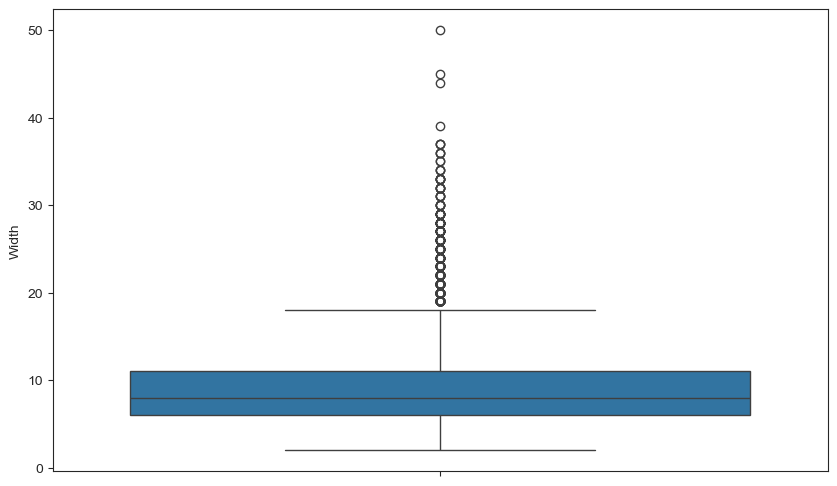

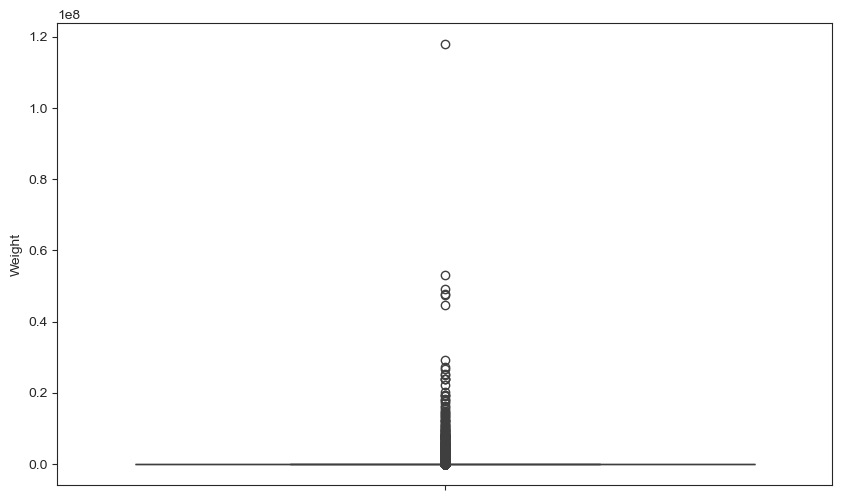

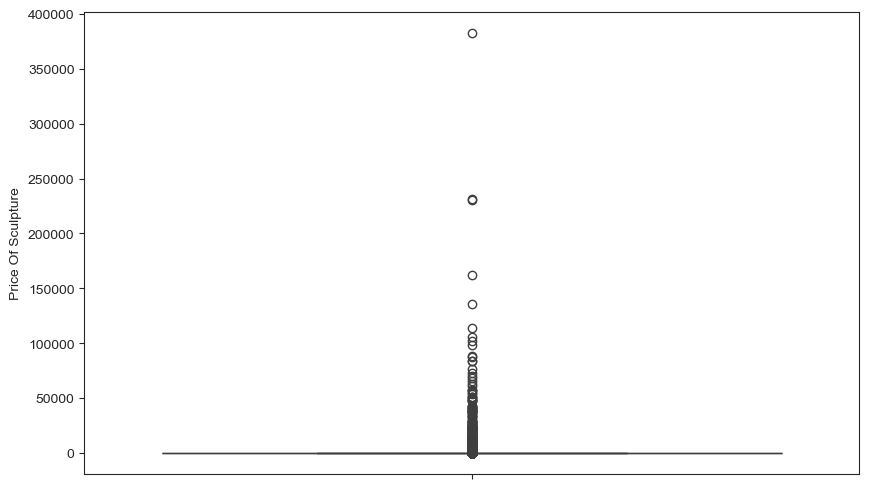

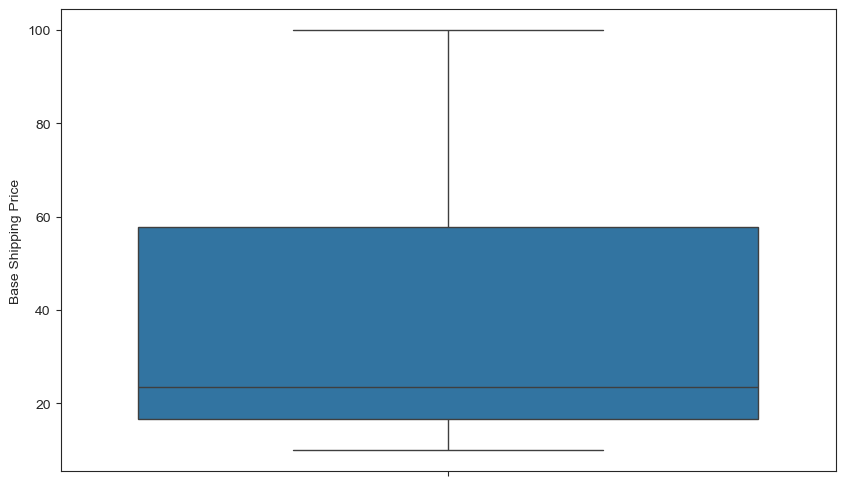

In [63]:
for i in numeric_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df1[i])

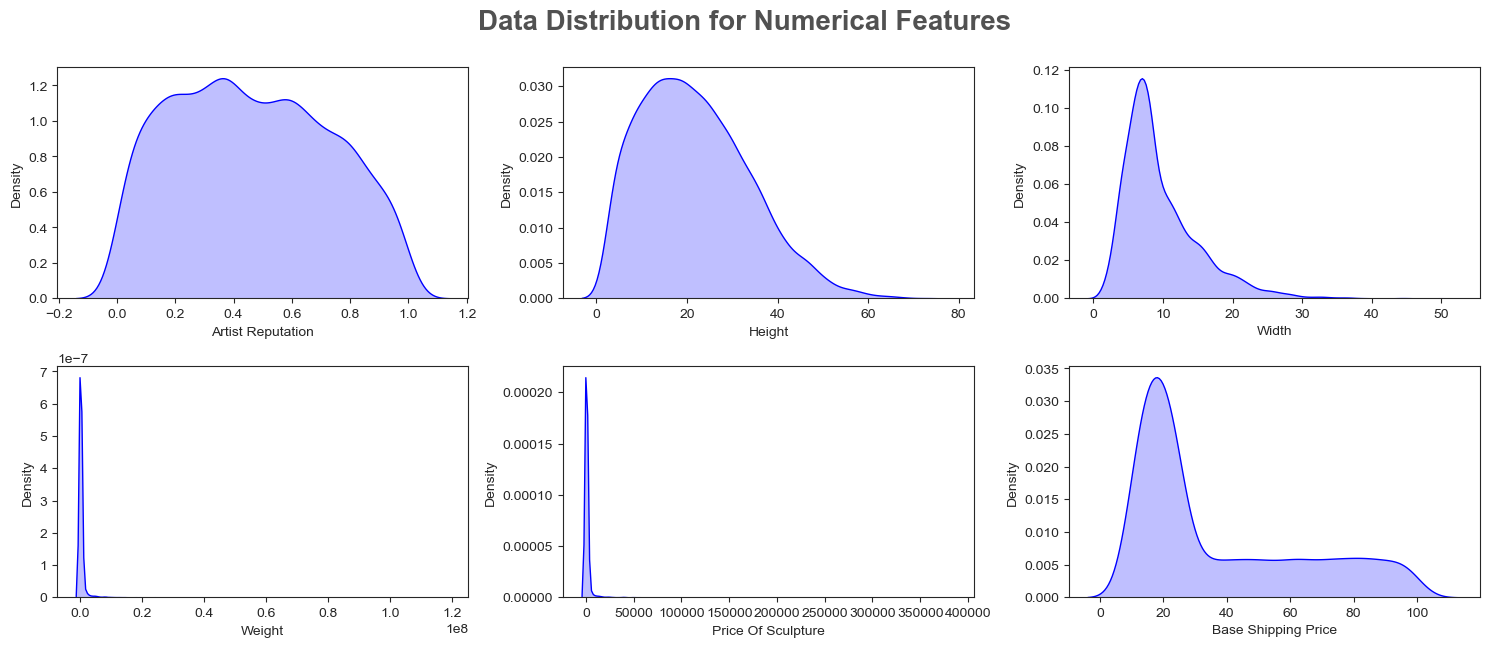

In [64]:
plt.figure(figsize=(15, 15))
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=df[numeric_features[i]],shade=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

In [65]:
df[numeric_features].skew()

Artist Reputation       0.141363
Height                  0.594041
Width                   1.546702
Weight                 21.556174
Price Of Sculpture     22.206823
Base Shipping Price     0.918102
dtype: float64

**Insighs**

 - From EDA we have seen that the `Price Of Sculpture ` and `Weight` were extremely positively skewed may be because outliers

 - So we can handle this type of case using Power Transformer or log transformer
 
 - `Width` and `Base Shipping Price` too are slighty positively skewed but not severe as shown by skewness coefficient.


#### Checking the power transformer on outlier columns

In [66]:
outlier_feature = ['Price Of Sculpture', 'Weight']

In [67]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(standardize=False)

outlier_data = df1[outlier_feature]

In [68]:
df1[outlier_feature] = pt.fit_transform(df1[outlier_feature])

In [69]:
df_outlier = pd.DataFrame(outlier_data, columns=outlier_feature)

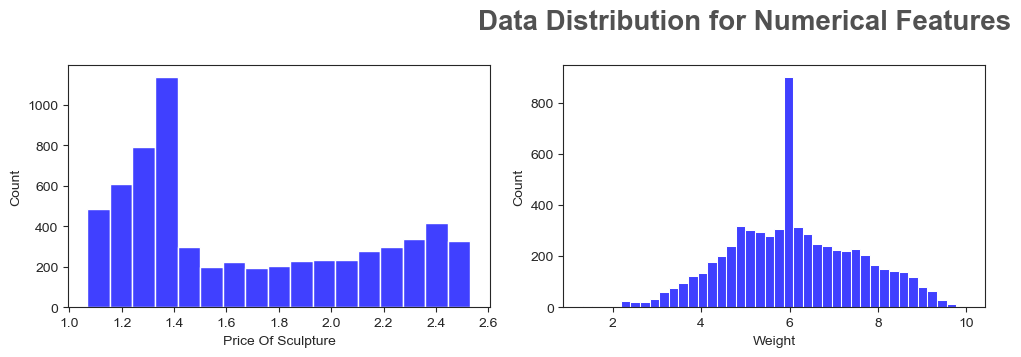

In [70]:
plt.figure(figsize=(15, 15))
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(outlier_feature)):
    plt.subplot(5, 3, i+1)
    sns.histplot(x=df1[outlier_feature[i]], color='b')
    plt.xlabel(outlier_feature[i])
    plt.tight_layout()


In [71]:
df1[outlier_feature].skew()

Price Of Sculpture    0.478648
Weight                0.027309
dtype: float64

**Insights**
 - Power transformer does a better job at overcoming skewness and handling outliers

**Why outliers?**
* Data Entry error : Human error. 
* Measurement error: Instrument error. 
* Natural error: it will be Real life data.
* Intentional error: People give wrong inputs

**Impact of Outliers ?**
* Ouliers can very high impact on few Machine learning models.
* Can Cause bias in the output.

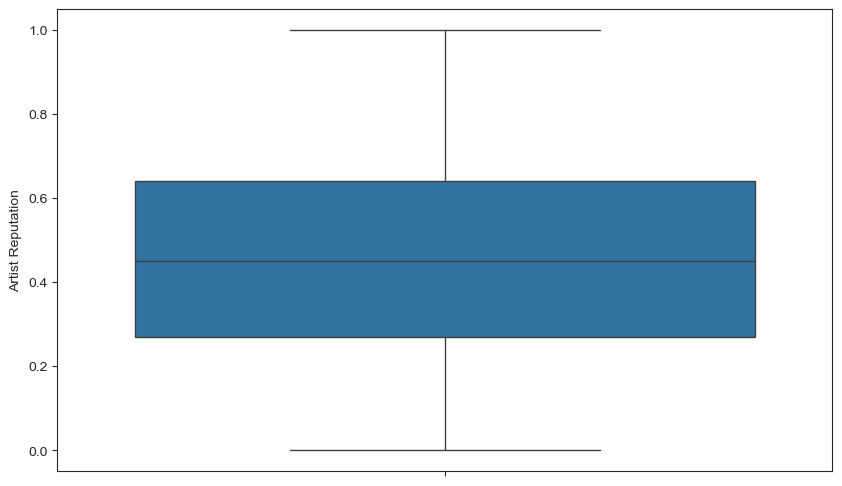

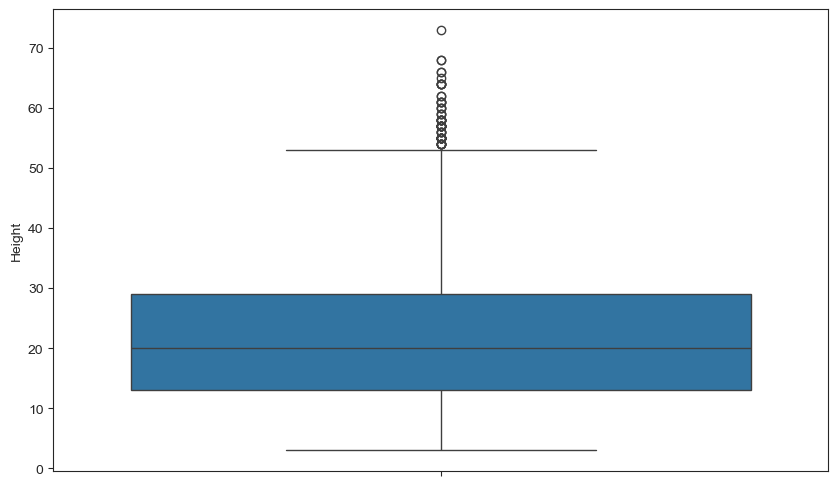

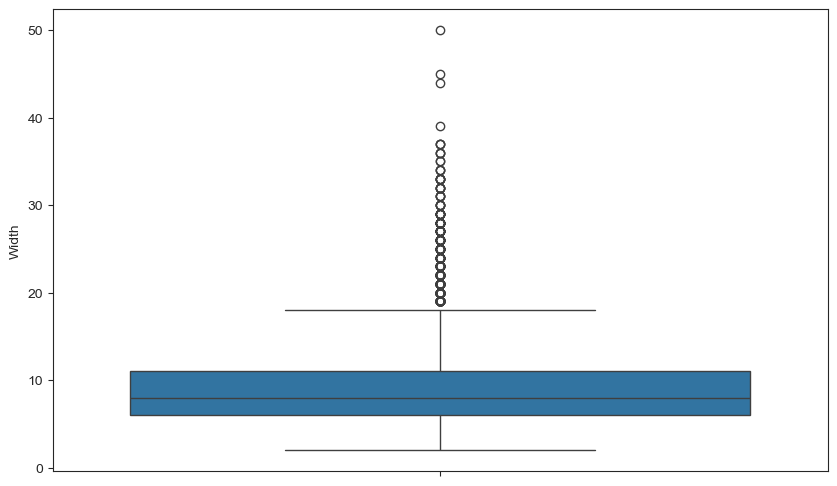

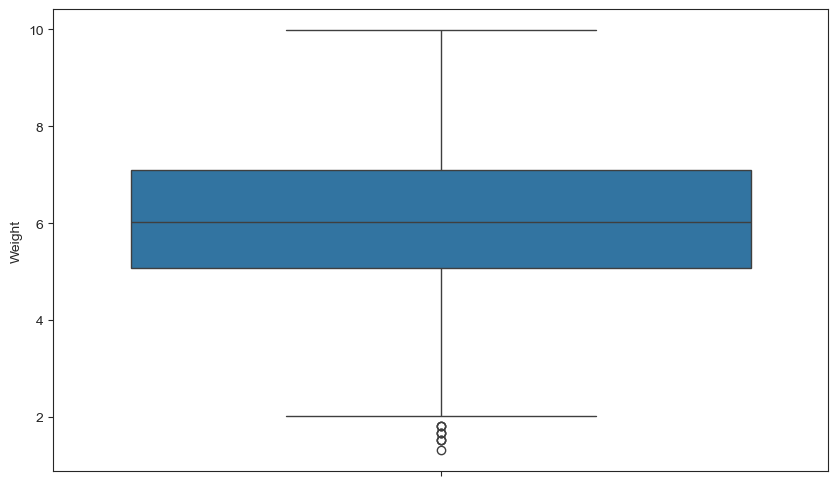

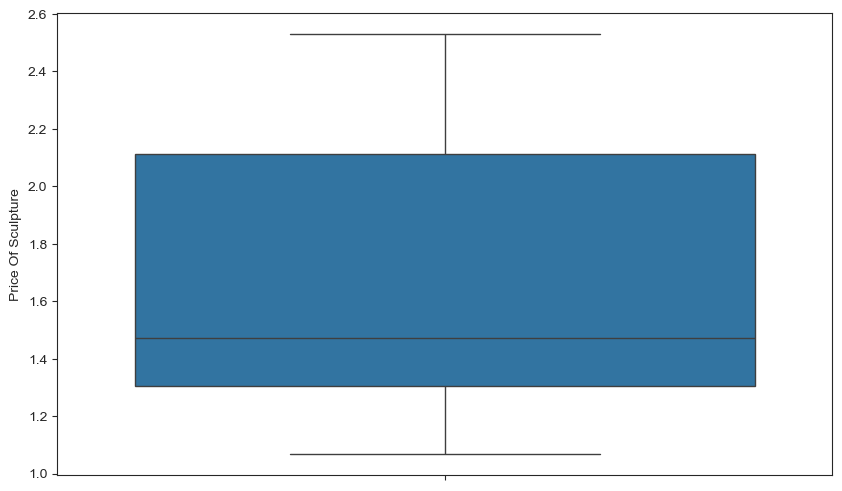

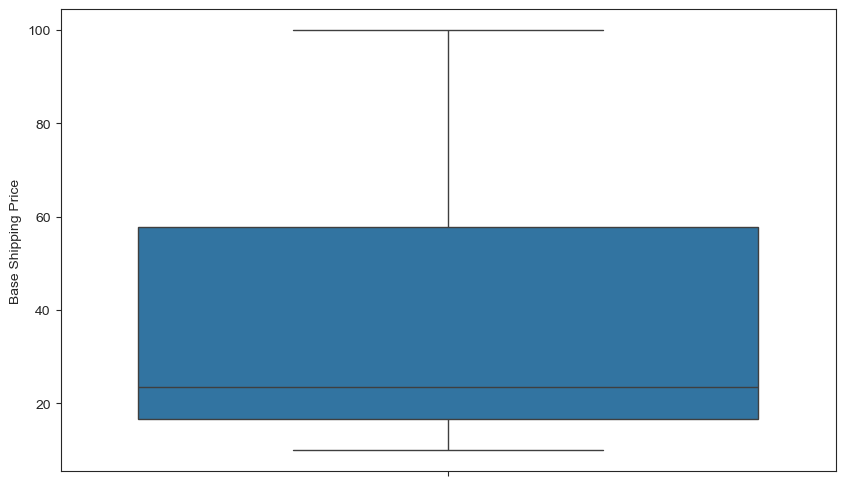

In [72]:
for i in numeric_features:
    plt.figure(figsize=(10,6))
    sns.set_style('ticks')
    ax = sns.boxplot(df1[i])

#### Removing outliers from Target Column
* Because most model would perform better on noiseless data, as Outlier might skew the findings of your model in one direction

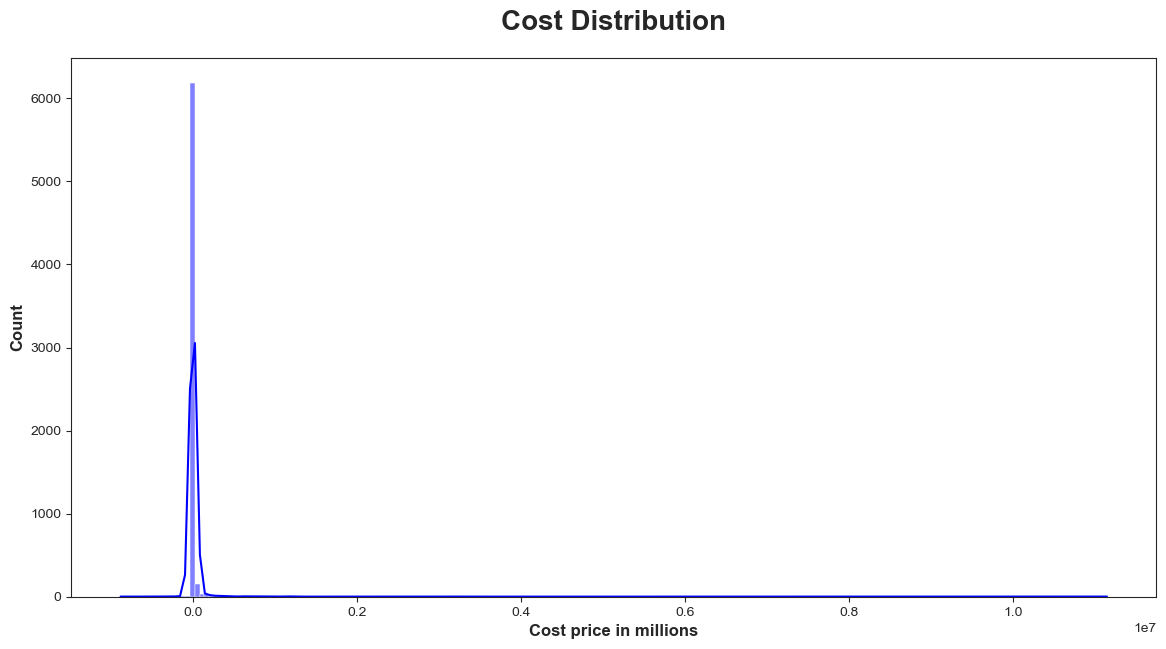

In [73]:
plt.subplots(figsize=(14,7))
sns.histplot(df['Cost'], bins=200, kde=True, color = 'b')
plt.title("Cost Distribution", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.xlabel("Cost price in millions", weight="bold", fontsize=12)
plt.show()

Need to apply transformation to target column to make it normally distributed. we use 1p to avoid `inf` values arise dued to `0` in the target column

In [74]:
df1['Cost'] = np.log1p(df1['Cost'])

(array([1973., 1985.,  954.,  461.,  223.,  127.,   64.,   32.,   16.,
           6.]),
 array([ 4.46671239,  5.64267721,  6.81864203,  7.99460685,  9.17057167,
        10.34653649, 11.5225013 , 12.69846612, 13.87443094, 15.05039576,
        16.22636058]),
 <BarContainer object of 10 artists>)

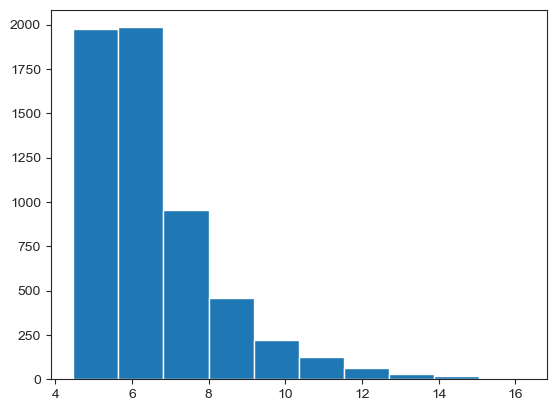

In [75]:
plt.hist(df1['Cost'])

Data looks good after the log transformation but not Normally distributed.

#### Feature Creation for Date Columns

In [76]:
# Convert object datatype to datetime
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'])
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])

In [77]:
df['Month'] = pd.to_datetime(df['Scheduled Date']).dt.month
df['Year'] = pd.to_datetime(df['Scheduled Date']).dt.year

numeric_features.append('Month')
numeric_features.append('Year')

#### Drop Unneccessary column

Drop `Customer Id`, `Artist Name` and `Customer Location` columns having huge number of unique values.

`Scheduled Date` and `Delivery Date` can be dropped since the required features are extracted form it

In [78]:
to_drop_columns = ['Customer Id', 'Artist Name', 'Customer Location', 'Scheduled Date', 'Delivery Date']

In [79]:
df.drop(columns=to_drop_columns, inplace=True)

In [80]:
!pip install catboost

In [81]:
!pip install xgboost

### Model Building

In [82]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler, PowerTransformer, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

### Split X and y

In [83]:
X = df.drop(columns = ['Cost'], axis=1)
y = np.abs(df['Cost'])

In [84]:
y = np.log1p(y)

## Train Test Split

* The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

* It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Encoding and Scaling

**Selecting Numerical and categorical features for feature scaling**

In [86]:
numeric_features = [x for x in numeric_features if x not in outlier_feature]
categorical_features = [x for x in non_numeric_features if x not in to_drop_columns]

(numeric_features), (categorical_features), (outlier_feature)

(['Artist Reputation',
  'Height',
  'Width',
  'Base Shipping Price',
  'Month',
  'Year'],
 ['Material',
  'International',
  'Express Shipment',
  'Installation Included',
  'Transport',
  'Fragile',
  'Customer Information',
  'Remote Location'],
 ['Price Of Sculpture', 'Weight'])

* **Mean imputer:** Since we handeled outlier by powertransformer for the continuous features the mean and median of the features are nearly same. When there are no outliers mean performs an a better imputer.
* **Standardscaler:** As the features distribution are nearly normal we use standard scaler.
* **Power Transformer:** Since avg_glucose_level are skewed we use Power Transformer on them

In [87]:
numeric_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder()),
]
)

outliers_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', PowerTransformer(standardize=True))
])

preprocessor = ColumnTransformer(
    [
        ("Numeric Pipeline",numeric_features_pipeline, numeric_features),
        ("Categorical Features Pipeline",categorical_features_pipeline, categorical_features),
        ("Outliers Features Pipeline", outliers_features_pipeline, outlier_feature)
]
)

In [88]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [92]:
!pip install scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Define the models dictionary 
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor()
}

# Now you can call evaluate_models
base_report = evaluate_models(X_train, X_test, y_train, y_test, models)

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.7357
- Mean Absolute Error: 0.4971
- R2 Score: 0.8014
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.6966
- Mean Absolute Error: 0.4841
- R2 Score: 0.8218


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.5268
- Mean Absolute Error: 0.3278
- R2 Score: 0.8981


Random Forest
Model performance for Training set
- Root Mean Squared Error: 0.1240
- Mean Absolute Error: 0.0795
- R2 Score: 0.9944
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3502
- Mean Absolute Error: 0.2055
- R2 Score: 0.9549




## Model Selection
* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

In [93]:
# functions which takes true and predicted values to calculate metrics
def evaluate_reg(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [95]:
# function which can evaluate models and return a report 
def evaluate_models(X_train, X_test, y_train, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''    
    models_list = []
    r2_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate Train and Test dataset
        model_train_mae , model_train_rmse, model_train_r2 = evaluate_reg(y_train, y_train_pred)

        model_test_mae , model_test_rmse, model_test_r2 = evaluate_reg(y_test, y_test_pred)


        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
        print("- R2 Score: {:.4f}".format(model_train_r2))

        print('----------------------------------')

        print('Model performance for Test set')
        print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
        print("- R2 Score: {:.4f}".format(model_test_r2))
        r2_list.append(model_test_r2)

        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, r2_list)), columns=['Model Name', 'r2_score']).sort_values(by=['r2_score'], ascending=False)
        
    return report

In [96]:
base_report = evaluate_models(X_train, X_test, y_train, y_test, models)

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.7357
- Mean Absolute Error: 0.4971
- R2 Score: 0.8014
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.6966
- Mean Absolute Error: 0.4841
- R2 Score: 0.8218


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.5259
- Mean Absolute Error: 0.3254
- R2 Score: 0.8984


Random Forest
Model performance for Training set
- Root Mean Squared Error: 0.1228
- Mean Absolute Error: 0.0787
- R2 Score: 0.9945
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3542
- Mean Absolute Error: 0.2032
- R2 Score: 0.9539




In [97]:
# Initialize models required for model
models = {
    "Linear Regression": LinearRegression(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False, max_depth=5),
    "AdaBoost Regressor": AdaBoostRegressor(), 
    "SVR": SVR()
}

In [98]:
base_report

,Model Name,r2_score
2,Random Forest,0.953922
1,Decision Tree,0.898396
0,Linear Regression,0.821773


#### Hyperparameter Tuning

In [99]:
#Initialize few parameter for Hyperparamter tuning
rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

cat_params = {"learning_rate": [0.1, 0.01, 0.6, 0.5],
              "max_depth": [4, 5, 6, 8, 12]}

In [100]:
# Models list for Hyperparameter tuning
randomcv_models = [("RF", RandomForestRegressor(), rf_params),
                   ('XGBoost', XGBRegressor(), xgboost_params),
                   ('CatBoost', CatBoostRegressor(verbose=False), cat_params)
                   ]

In [101]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
---------------- Best Params for RF -------------------
{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 8, 'max_depth': 15}
---------------- Best Params for XGBoost -------------------
{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
---------------- Best Params for CatBoost -------------------
{'max_depth': 5, 'learning_rate': 0.1}


In [102]:
# reInitialize models with best parameters
models = {
    "Random Forest Regressor": RandomForestRegressor(**model_param['RF'], n_jobs=-1),
    "XGBRegressor": XGBRegressor(**model_param['XGBoost'], n_jobs=-1), 
     "CatBoosting Regressor": CatBoostRegressor(**model_param['CatBoost'],verbose=False)
}

In [103]:
retrained_report = evaluate_models(X_train, X_test, y_train, y_test, models)

Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1552
- Mean Absolute Error: 0.0995
- R2 Score: 0.9912
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3652
- Mean Absolute Error: 0.2270
- R2 Score: 0.9510


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 0.1429
- Mean Absolute Error: 0.0909
- R2 Score: 0.9925
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.2903
- Mean Absolute Error: 0.1679
- R2 Score: 0.9690


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1461
- Mean Absolute Error: 0.0956
- R2 Score: 0.9922
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.2789
- Mean Absolute Error: 0.1609
- R2 Score: 0.9714




In [104]:
retrained_report

,Model Name,r2_score
2,CatBoosting Regressor,0.971419
1,XGBRegressor,0.969041
0,Random Forest Regressor,0.950995


### Best Model is CATBoost Regressor with 97.17% Score